In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
RAND_SEED=1

# 随机过程  
## gaussian 分布
  $\sigma$是标准差，$\mu$是平均值。  
$$
f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}
$$

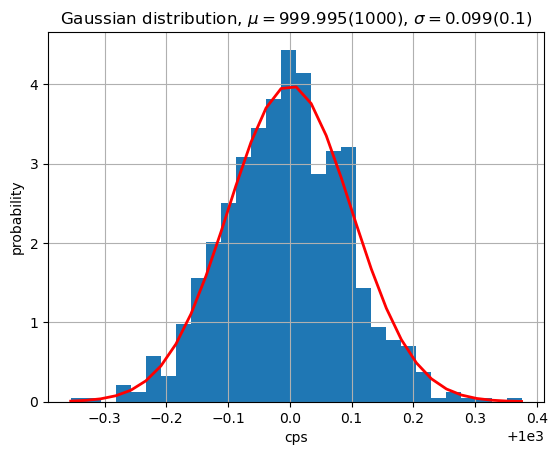

In [2]:
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))

mu, sigma = 1000, 0.1 # mean and standard deviation
rng = np.random.default_rng(seed=RAND_SEED)
s = rng.normal(mu, sigma, 1000)
count, bins, _ = plt.hist(s, 30, density=True)
plt.plot(bins, gaussian(bins, mu, sigma), linewidth=2, color='r')
plt.title('Gaussian distribution, $\mu={:.3f}({})$, $\sigma={:.3f}({})$'.format(s.mean(),mu,s.std(), sigma))
plt.grid()
plt.xlabel('cps')
plt.ylabel('probability')
plt.show()

In [3]:
sig0=(rng.normal(0,3,int(1e6)))
sig=np.cumsum(sig0)
sig1=sig[:-10]
sig2=sig[10:]
delt=sig2-sig1
print('std:',sig1.std(),sig2.std(),delt.std(),delt.var())


std: 853.5720453868051 853.5615161935714 9.48899444513881 90.04101557987518


In [4]:
shot_noise=rng.poisson(100,sig.size)
delt_com=sig2-(sig1+shot_noise[10:]-100)
print('std:',delt_com.std(),delt_com.var())


std: 13.795141776244309 190.305936626681


In [5]:
c0=delt_com.mean()/10
np.std(sig2-np.cumsum(np.sign(delt_com)*c0))

853.7966939003853

In [6]:
c0=delt_com.mean()/100000
np.std(sig-np.cumsum(np.sign(sig)*c0))

853.585906958195

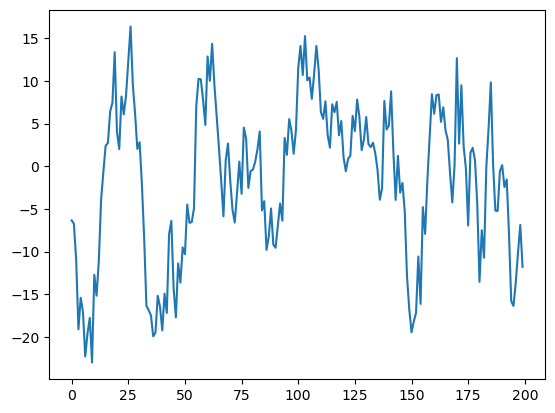

In [7]:
plt.plot(delt[:200])

## 泊松分布  
大N的二项式分布的极限。其中$\lambda$可以认为探测器探测到的光子数量,poisson分布的mean=std    
$$
P(X=k)=\frac{\lambda^k e^{-\lambda}}{k!}
$$

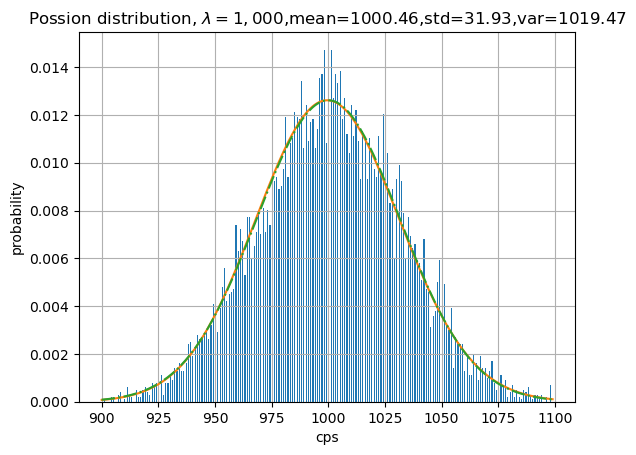

In [8]:
from scipy import stats
lam, size = 1000, 10000
s = rng.poisson(lam=lam, size=size)
x = np.arange(lam-100,lam+100)
pmf = stats.poisson.pmf(x, mu=lam)
count, bins, _ =plt.hist(s, bins=x, density=True, width=0.5)
plt.plot(x, pmf, '-')
plt.plot(x,gaussian(x, mu=lam, sigma=np.sqrt(lam)), '-.')
plt.title('Possion distribution, $\lambda={:,.0f}$,mean={:.2f},std={:.2f},var={:.2f}'.format(lam,s.mean(),s.std(),s.var()))
plt.grid()
plt.xlabel('cps')
plt.ylabel('probability')
plt.show()

# 模拟  
对于Possion分布  
假设探测效率100%，探测引入的possion分布来自于探测器的探测效率，即探测到光子数量服从possion分布，而光子数量与探测效率是独立的。  
$\lambda$是探测到的光子数量。定义为平均的光子数。


In [9]:
time=np.arange(0,1e6,1)
dsig=rng.normal(0,3,len(time))
sig=np.cumsum(dsig)
##-----------测量
sample_time=10 #[ms] 反馈时间 也是采样时间 tau
det_time=time[::sample_time]
det_sig=sig[::sample_time]
shot_noise=(rng.poisson(lam=1e2,size=len(det_sig))-1e2)
det_o=det_sig+shot_noise
_=dict(mean=[dsig.mean(),sig.mean(),det_sig.mean(),det_o.mean()],
       std=[dsig.std(),sig.std(),det_sig.std(),det_o.std()],
       var=[dsig.var(),sig.var(),det_sig.var(),det_o.var()],
       )
df=pd.DataFrame(_,index=['dsig','sig','det_sig','det_o']).T
print(df)

          dsig           sig       det_sig         det_o
mean  0.004915  3.004217e+03  3.004195e+03  3.004220e+03
std   3.003897  1.426712e+03  1.426717e+03  1.426723e+03
var   9.023397  2.035506e+06  2.035522e+06  2.035538e+06


In [10]:
feedback_sig=np.r_[det_o[0],np.diff(det_o)] #以采样时间的延时反馈
df['feedback_sig']=[feedback_sig.mean(),feedback_sig.std(),feedback_sig.var()]
print(df)
print('十个点的方差：',np.var(det_sig[1:]-(det_sig[:-1])),'possion的方差：',shot_noise.var())
print('feedback_sig的方差=var(speed)*反馈时间内点数+var(shot noise)')

          dsig           sig       det_sig         det_o  feedback_sig
mean  0.004915  3.004217e+03  3.004195e+03  3.004220e+03      0.049107
std   3.003897  1.426712e+03  1.426717e+03  1.426723e+03     17.038943
var   9.023397  2.035506e+06  2.035522e+06  2.035538e+06    290.325591
十个点的方差： 90.3484427016811 possion的方差： 99.7804838759
feedback_sig的方差=var(speed)*反馈时间内点数+var(shot noise)


探测噪声与信号强度有关，当信号强度的高于gaussian的方差时，反馈后的信号方差中，探测造成的possion噪声占主导地位。

In [31]:
feedback_sig_delay=np.r_[0,feedback_sig[1:]]
#feedback_sig_delay=feedback_sig
c0=0.9#feedback_sig_delay/sample_time
fb_sign=np.tile(np.sign(feedback_sig_delay),(sample_time,1)).T
out=dsig.reshape((-1,sample_time))-fb_sign*np.tile(c0,(sample_time,1)).T
out=out.reshape(-1)
out=np.cumsum(out)
out_o=out[::sample_time]
df['quick_fb']=[out.mean(),out.std(),out.var()]
df['quick_fb_o']=[out_o.mean(),out_o.std(),out_o.var()]
print(df)
df

          dsig           sig       det_sig         det_o  feedback_sig  \
mean  0.004915  3.004217e+03  3.004195e+03  3.004220e+03      0.049107   
std   3.003897  1.426712e+03  1.426717e+03  1.426723e+03     17.038943   
var   9.023397  2.035506e+06  2.035522e+06  2.035538e+06    290.325591   

          quick_fb    quick_fb_o  
mean  1.415803e+03  1.415788e+03  
std   1.218866e+03  1.218857e+03  
var   1.485635e+06  1.485613e+06  


,dsig,sig,det_sig,det_o,feedback_sig,quick_fb,quick_fb_o
mean,0.004915,3.004217e+03,3.004195e+03,3.004220e+03,0.049107,1.415803e+03,1.415788e+03
std,3.003897,1.426712e+03,1.426717e+03,1.426723e+03,17.038943,1.218866e+03,1.218857e+03
var,9.023397,2.035506e+06,2.035522e+06,2.035538e+06,290.325591,1.485635e+06,1.485613e+06


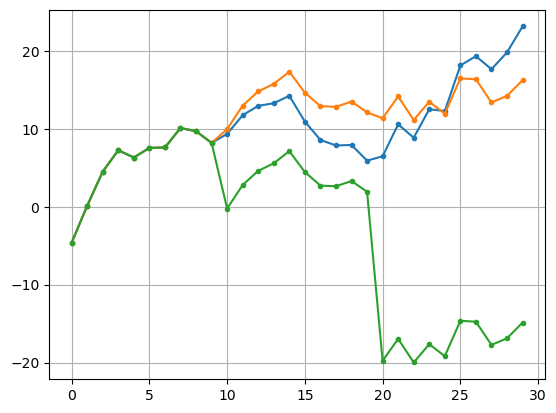

In [231]:
out=np.zeros_like(dsig).reshape((-1,sample_time))
feedback_sig=np.zeros_like(out)
c0=0
for i,array in enumerate(dsig.reshape((-1,sample_time))):
    if i==0:
        out[i]=np.cumsum(array)
        feedback_sig[i]=np.cumsum(array)
    else:
        shot_noise=rng.poisson(100)-100
        c0=(out[i-1][-1])+shot_noise
        feedback_sig[i]=np.cumsum(array)+shot_noise
        out[i]=out[i-1][-1]+np.cumsum(array-c0/sample_time)
out=out.reshape(-1)
feedback_sig=feedback_sig.reshape(-1)
feedback_sig_o=feedback_sig[sample_time-1::sample_time]
out_o=out[sample_time-1::sample_time]
plt.plot(out[:30],'.-')
plt.plot(sig[:30],'.-')
plt.plot(feedback_sig[:30],'.-')
plt.grid()

In [278]:
from tqdm import tqdm
window_out=np.zeros_like(sig)
window_out_b0=np.r_[np.zeros(9),sig]
for i in tqdm(range(window_out.size)):
    shot_noise=rng.poisson(1)-1
    fb=np.sum(window_out_b0[i:i+10])
    if i ==0:
        window_out[i]=window_out_b0[9+i]
    else:
        window_out[i]=window_out_b0[9+i]-(fb+shot_noise)
        window_out_b0[9+i]-=fb
window_out_o=window_out[sample_time-1::sample_time]

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:09<00:00, 107832.01it/s]


380.29352868191665


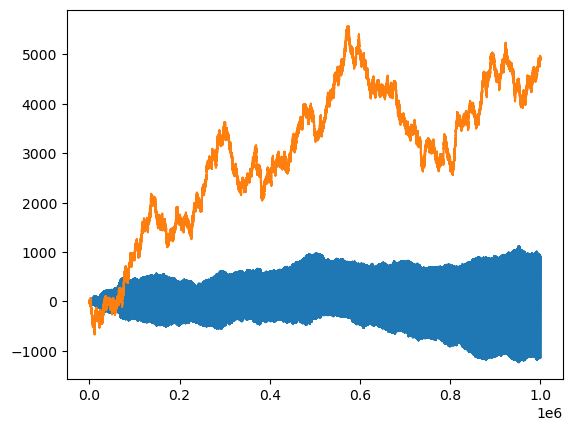

In [279]:
print(np.std(window_out))
plt.plot(window_out)
plt.plot(sig)

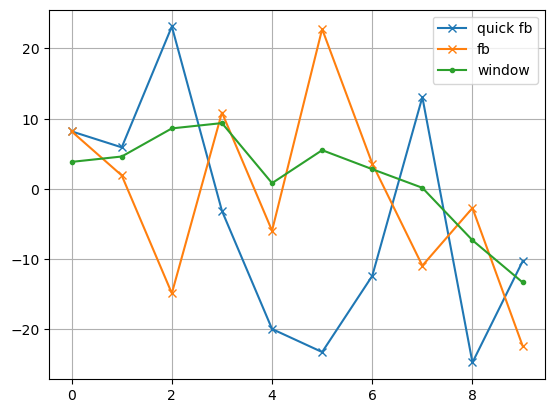

In [265]:
plt.plot(out_o[:10],'x-',label='quick fb')
plt.plot(feedback_sig_o[:10],'x-',label='fb')
plt.plot(window_out_o[:10],'.-',label='window')
plt.legend()
plt.grid()
plt.legend()

In [245]:
print('SR=0.1M:')
print(np.var(out_o),np.var(feedback_sig_o),np.var(dsig))
print('SR=1M:')
print(np.std(out),np.std(feedback_sig),np.std(dsig),np.std(window_out))

SR=0.1M:
189.2262611697 192.260874766019 9.023397394537792
SR=1M:
11.902792696038256 12.271341739572472 3.00389703460984 675.8151625937269


quick_fb的std接近于漂移速率

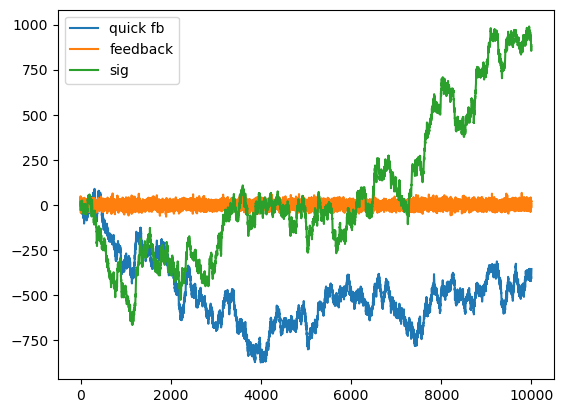

In [37]:
plt.plot(out_o[:10000],label='quick fb')
plt.plot(feedback_sig[:10000],label='feedback')
plt.plot(det_sig[:10000],label='sig')
plt.legend()

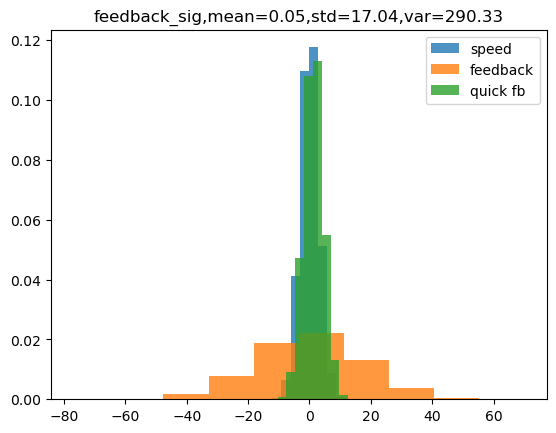

In [12]:
plt.hist(dsig,alpha=0.8,label='speed',density=True)
plt.hist(feedback_sig,alpha=0.8,label='feedback',density=True)
plt.hist(out[::sample_time],alpha=0.8,label='quick fb',density=True)
plt.title('feedback_sig,mean={:.2f},std={:.2f},var={:.2f}'.format(feedback_sig.mean(),feedback_sig.std(),feedback_sig.var()))
plt.legend()
plt.show()

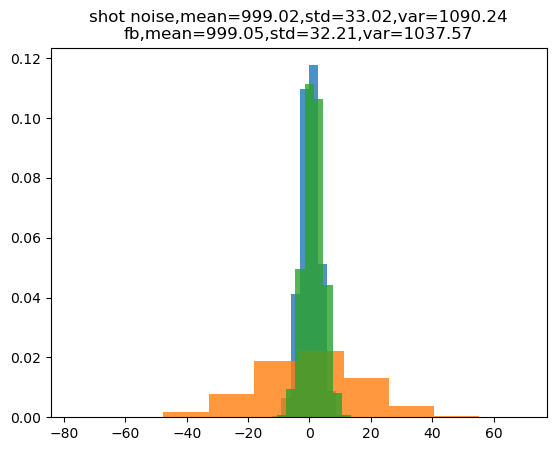

In [13]:
c0=1
shot_noise=rng.poisson(lam=1e3,size=1000)
fb=shot_noise-np.sign(shot_noise-1e3)*c0
plt.hist(dsig,alpha=0.8,density=True,label='speed')
plt.hist(feedback_sig,alpha=0.8,density=True)
plt.hist(out,alpha=0.8,density=True)
a=('shot noise,mean={:.2f},std={:.2f},var={:.2f}\n'.format(shot_noise.mean(),shot_noise.std(),shot_noise.var()))
plt.title(a+'fb,mean={:.2f},std={:.2f},var={:.2f}'.format(fb.mean(),fb.std(),fb.var()))
plt.show()

In [14]:
np.r_[det_o[0],np.diff(det_o)].size

100000